In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve,
    auc
)
import sklearn, matplotlib, shap, nltk

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [74]:
pd.__version__, np.__version__, nltk.__version__, sklearn.__version__, matplotlib.__version__, shap.__version__,

pd.set_option('display.max_colwidth', 1000)


In [5]:
plt.rcParams["font.family"] = "Times New Roman"


## Input info

In [69]:
usda_foods = pd.read_csv('../data_discovery/all_branded_foods_usda_searchable.csv', index_col=0)

In [6]:
entity_flavor_molecules_name_reduced = pd.read_pickle('../data_discovery/processed/entity_flavor_molecules_name_reduced.pkl')
entity_flavor_profile_reduced = pd.read_pickle('../data_discovery/processed/entity_flavor_profile_reduced.pkl')
entity_functional_group_reduced = pd.read_pickle('../data_discovery/processed/entity_functional_group_reduced.pkl')
entity_nutrition_facts = pd.read_pickle('../data_discovery/processed/entity_nutrition_facts.pkl')

In [7]:
base_ingredients = pd.Series(pd.read_pickle('../data_discovery/processed/available_ingredients.pkl').index)
model = pd.read_pickle('../models/first_model.pkl')

In [8]:
x_train = pd.read_parquet('../data_discovery/processed/x_train.parquet')
x_test = pd.read_parquet('../data_discovery/processed/x_test.parquet')
y_train = pd.read_parquet('../data_discovery/processed/y_train.parquet')
y_test = pd.read_parquet('../data_discovery/processed/y_test.parquet')

In [9]:
train_test_samples = pd.read_parquet('../data_discovery/processed/fdc_ids_for_train_test.parquet')

In [10]:
all_samples = pd.read_parquet('../data_discovery/processed/all_similar_combinations.parquet')

In [11]:
features = pd.read_parquet('../data_discovery/processed/features_for_fdc_ids.parquet')

In [12]:
train_test_samples['fdc_id_st'] = train_test_samples['fdc_id_source'].astype('str') + '__' + train_test_samples['fdc_id_target'].astype('str')

In [13]:
all_samples['fdc_id_st'] = all_samples['fdc_id_source'].astype('str') + '__' + all_samples['fdc_id_target'].astype('str')

In [14]:
#simulation = all_samples[all_samples.fdc_id_st.isin(train_test_samples.loc[y_train.index].fdc_id_st)]

In [15]:
#simulation.similar.mean()

In [16]:
test_fdcids = list(set(list(train_test_samples.loc[y_test.index].fdc_id_source.unique()) + list(train_test_samples.loc[y_test.index].fdc_id_target.unique())))

In [17]:
train_fdcids = list(set(list(train_test_samples.loc[y_train.index].fdc_id_source.unique()) + list(train_test_samples.loc[y_train.index].fdc_id_target.unique())))

In [18]:
# No intersecction between train and test fdc_ids. 
set(test_fdcids).intersection(train_fdcids)

set()

In [19]:
remaining_samples = all_samples[
    (~all_samples.fdc_id_source.isin(train_fdcids)) & # Exclude training set in source
    (~all_samples.fdc_id_target.isin(train_fdcids)) & # Exclude training set in target
    (~all_samples.fdc_id_st.isin(train_test_samples.loc[y_train.index].fdc_id_st))  # Exclude already verified train samples. 
]

In [20]:
remaining_samples_features = remaining_samples.sample(frac=0.1).merge(
    features.reset_index(), left_on='fdc_id_source', right_on='fdc_id'
).drop('fdc_id', axis=1).merge(features.reset_index(), left_on='fdc_id_target', right_on='fdc_id').drop('fdc_id', axis=1)

In [42]:
remaining_samples_features

,fdc_id_source,fdc_id_target,similar,fdc_id_st,common_name__0_x,common_name__1_x,common_name__2_x,common_name__3_x,common_name__4_x,common_name__5_x,...,VITB6A_y,FOLDFE_y,FOLFD_y,FOLAC_y,VITB12_y,VITD_y,TOCPHA_y,VITK1_y,WATER_y,SUGAR.added_y
0,2317157,1714263,0,2317157__1714263,-1.181572,0.368558,0.008604,-0.573958,-1.073708,-0.227200,...,0.034000,10.666667,10.666667,0.0,0.516667,0.633333,0.260000,0.90,41.700000,0.000000
1,2233297,1714263,1,2233297__1714263,-2.836469,2.681046,-0.276044,1.232074,-0.306087,0.419507,...,0.034000,10.666667,10.666667,0.0,0.516667,0.633333,0.260000,0.90,41.700000,0.000000
2,2518356,1714263,0,2518356__1714263,-2.064849,0.338179,-0.017978,-0.505922,-0.671526,-0.088463,...,0.034000,10.666667,10.666667,0.0,0.516667,0.633333,0.260000,0.90,41.700000,0.000000
3,576740,1714263,0,576740__1714263,-2.334536,0.818599,0.204818,-0.576096,-0.502719,0.702787,...,0.034000,10.666667,10.666667,0.0,0.516667,0.633333,0.260000,0.90,41.700000,0.000000
4,2393126,1714263,0,2393126__1714263,-2.250930,0.306729,0.262252,-0.781637,-0.769509,-0.276664,...,0.034000,10.666667,10.666667,0.0,0.516667,0.633333,0.260000,0.90,41.700000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308349,1163560,2222983,0,1163560__2222983,0.744821,1.824992,1.226495,-0.849218,-0.620992,-0.192718,...,0.052667,11.166667,11.166667,0.0,0.000000,0.000000,0.178333,0.05,20.703333,16.633333
308350,626660,2222983,0,626660__2222983,0.067627,-1.096854,-0.378473,-0.159568,-0.090349,0.384973,...,0.052667,11.166667,11.166667,0.0,0.000000,0.000000,0.178333,0.05,20.703333,16.633333
308351,1243894,2222983,0,1243894__2222983,0.689065,-0.116927,-0.121057,-0.626335,-0.613146,0.091976,...,0.052667,11.166667,11.166667,0.0,0.000000,0.000000,0.178333,0.05,20.703333,16.633333
308352,1925058,2222983,0,1925058__2222983,-0.494149,-0.282501,0.194188,-0.389746,-0.548708,0.056233,...,0.052667,11.166667,11.166667,0.0,0.000000,0.000000,0.178333,0.05,20.703333,16.633333


In [51]:
non_predictor_columns = ['similar']
id_columns = ['fdc_id_source', 'fdc_id_target']
predictors = remaining_samples_features.set_index("fdc_id_st").drop(non_predictor_columns + id_columns, axis=1)


In [52]:
target = remaining_samples_features.set_index("fdc_id_st")[["similar"]]

In [54]:
def get_score(x_vals):
    result = model.predict_proba(x_vals)[:,1]
    return result

In [55]:
def quantify_results(x_vals, y_vals):
    results = pd.DataFrame()
    pred = get_score(x_vals)
    results['pred'] = pred
    results['similar'] = list(y_vals.similar)
    auc_roc = roc_auc_score(results.similar, results.pred)
    fpr, tpr, thresholds = roc_curve(results.similar, results.pred)
    aps = average_precision_score(results.similar, results.pred)
    precision, recall, th = precision_recall_curve(results.similar, results.pred) 
    auc_pr = auc(recall, precision)
    resume = {
        'AUC (ROC)': auc_roc,
        'AUC (PRC)': auc_pr,
        'Average Precision':aps,
    }
    roc_vals = fpr, tpr
    pr_vals = precision, recall
    return resume, roc_vals, pr_vals


def get_distributions(x_vals, y_vals):
    results = pd.DataFrame()
    pred = get_score(x_vals)
    results['pred'] = pred
    results['similar'] = list(y_vals.similar)
    return results
    

In [21]:
results_test, test_roc_vals, test_pr_vals = quantify_results(x_test, y_test)

In [112]:
test_samples = train_test_samples[train_test_samples.index.isin(x_test.index)]
pred_test = get_score(x_test)
test_samples['pred'] = pred_test
test_samples['similar'] = y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [129]:
#samples = test_samples[test_samples.pred>0.99].sample(1)
samples = test_samples[test_samples.pred.between(.7, 0.8)].sample(1)

prod1, prod2 = samples.fdc_id_source.iloc[0], samples.fdc_id_target.iloc[0]
sample_usda_foods = usda_foods[(usda_foods.fdc_id==prod1)|(usda_foods.fdc_id==prod2)]#.groupby('fdc_id')


pattern = r'[^\w\s]' #negacion de un caracter no presente en w (letras y numeros) ni s (espacios) 
from nltk.stem import PorterStemmer

def stem_list(word_list):
    stem_result = [PorterStemmer().stem(word) for word in word_list]
    return stem_result

similar_foods = pd.read_pickle('../data_discovery/similar_food_ingredients.pkl')

base_ingredients = pd.DataFrame()
base_ingredients['ingredients'] = pd.Series(similar_foods.index)
base_ingredients['ingredients_cleaned_list'] = base_ingredients.ingredients.str.lower().replace(pattern, '', regex=True).str.split(' ')
base_ingredients['stemmed_ingredients'] = base_ingredients.ingredients_cleaned_list.apply(stem_list)
base_ingredients['ingredients_cleaned'] = base_ingredients.stemmed_ingredients.str.join(' ')
base_ingredients['ingredients_for_search'] = ' ' + base_ingredients.ingredients_cleaned + ' '
base_ingredients.set_index('ingredients', inplace=True)

ingredients = base_ingredients.ingredients_for_search.to_dict()

usda_ingredients_results = []
i = 0
for real_ingredient, search_ingredient in ingredients.items():
    usda_ingredient_results = sample_usda_foods[sample_usda_foods.ingredient_searchable.str.contains(search_ingredient)]
    usda_ingredient_results['ing'] = real_ingredient
    usda_ingredients_results.append(usda_ingredient_results)
    #print(f'{i} {real_ingredient}', sep='; ')
    i+=1
usda_ingredients_repeated = pd.concat(usda_ingredients_results).groupby('fdc_id').agg(
    brand_owner = ('brand_owner', 'first'),
    ingredients = ('ingredients', 'first'),
    flavor_ingredients = ('ing', lambda x: list(x)),
    category = ('branded_food_category', 'first'),
    flavor_ingredients_count = ('ing', 'count'),
)
print(usda_ingredients_repeated.flavor_ingredients.to_list())
usda_ingredients_repeated

[['Soybean', 'Water'], ['Salt', 'Vinegar']]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,brand_owner,ingredients,flavor_ingredients,category,flavor_ingredients_count
fdc_id,,,,,
376753,"Nasoya Foods USA, LLC","WATER, ORGANIC WHOLE SOYBEANS, CALCIUM SULFATE, NIGARI (SEA WATER EXTRACT).","[Soybean, Water]",Other Meats,2
1182210,JR Frisco Inc.,"(CHAMOEDOREA SP.) PACAYA, VINEGAR, SALT AND PRESERVATIVE SODIUM BENZOATE 0.1%.","[Salt, Vinegar]",Canned Vegetables,2


[['Asparagus', 'Salt', 'Water'],
 ['Beans', 'Carrot', 'Corn', 'Green Beans', 'Peas']]

In [22]:
results_train, train_roc_vals, train_pr_vals = quantify_results(x_train, y_train)

In [25]:
results_remaining, remaining_roc_vals, remaining_pr_vals = quantify_results(predictors, target)

In [33]:
results_train, x_train.shape

({'AUC (ROC)': 0.9998284718639238,
  'AUC (PRC)': 0.9986950456822019,
  'Average Precision': 0.9986945767651846},
 (1674846, 408))

In [34]:
results_test, x_test.shape

({'AUC (ROC)': 0.9752394605125936,
  'AUC (PRC)': 0.8986110656810864,
  'Average Precision': 0.8958728000541863},
 (307924, 408))

In [36]:
results_remaining, predictors.shape

({'AUC (ROC)': 0.9757072678493934,
  'AUC (PRC)': 0.8984069928780578,
  'Average Precision': 0.8955321438490205},
 (308354, 408))

In [38]:
test = get_distributions(x_test, y_test)

In [232]:
y_test.similar.mean()

0.11586300515711669

In [72]:
test['q'] = pd.cut(test.pred, bins=25, duplicates='drop')

In [105]:
test_q.reset_index().reset_index()


,index,q,pred,similar,counts
0,0,"(-0.001, 0.04]",0.008630,0.002790,184611
1,1,"(0.04, 0.08]",0.062560,0.014365,34389
2,2,"(0.08, 0.12]",0.102801,0.038372,20197
3,3,"(0.12, 0.16]",0.142737,0.070291,13188
4,4,"(0.16, 0.2]",0.183004,0.117829,8716
5,5,"(0.2, 0.24]",0.222909,0.190788,5949
6,6,"(0.24, 0.28]",0.262856,0.254452,4268
7,7,"(0.28, 0.32]",0.302761,0.361077,3268
8,8,"(0.32, 0.36]",0.342539,0.479089,2415
9,9,"(0.36, 0.4]",0.383030,0.599349,1842


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

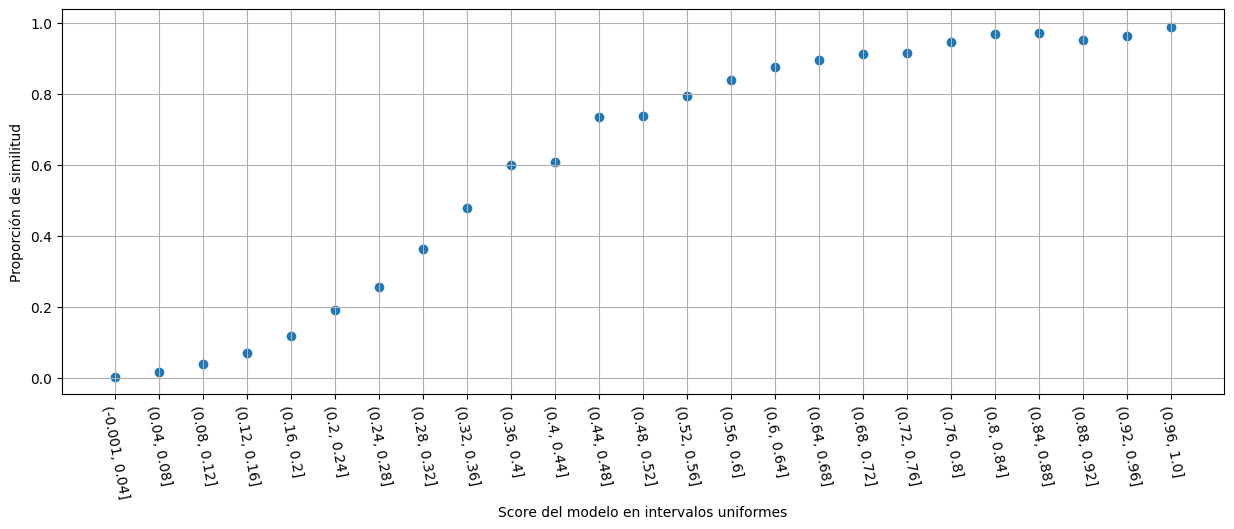

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

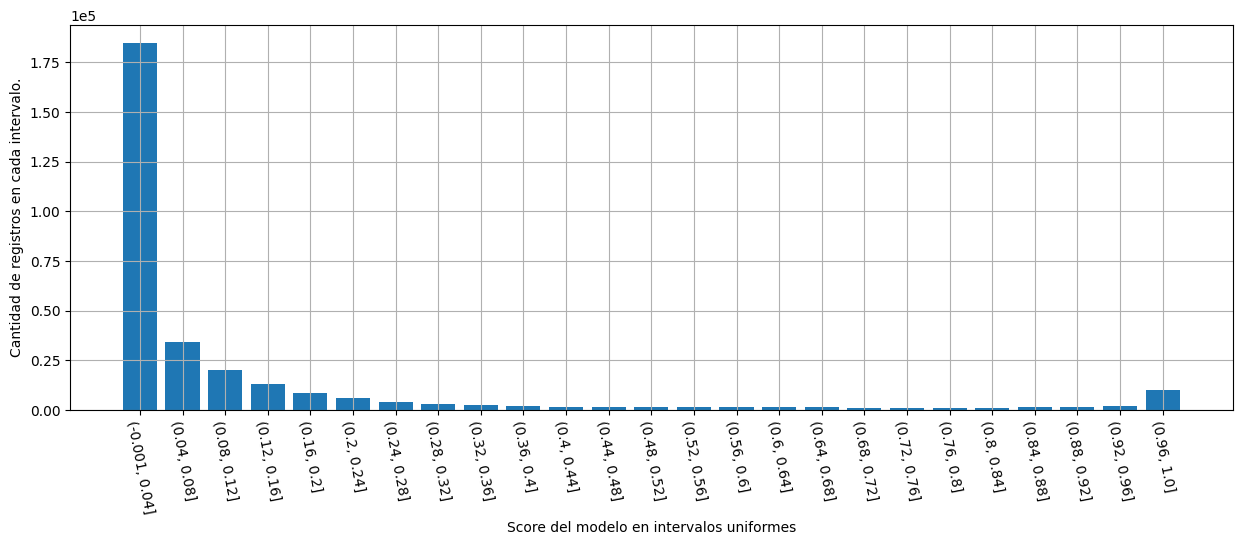

In [230]:
test_q = test.groupby('q').agg(
    pred=('pred', 'mean'),
    similar=('similar', 'mean'),
    counts=('pred', 'count'),
).sort_values('pred').reset_index().reset_index()
plt.figure(figsize=(15,5))
plt.scatter(test_q['index'], test_q.similar)
plt.xticks(np.arange(0,25, 1), test_q.q, rotation=-79,)
plt.xlabel("Score del modelo en intervalos uniformes")
plt.ylabel('Proporción de similitud')
plt.grid(which='major')

plt.figure(figsize=(15,5))
plt.bar(test_q['index'], test_q.counts)
plt.xticks(np.arange(0,25, 1), test_q.q, rotation=-79,)
plt.xlabel("Score del modelo en intervalos uniformes")
plt.ylabel('Cantidad de registros en cada intervalo.')
plt.grid(which='major')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,4))

#plt.grid(which='minor')



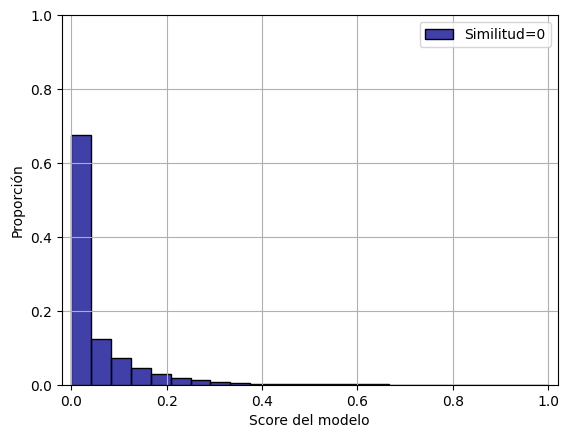

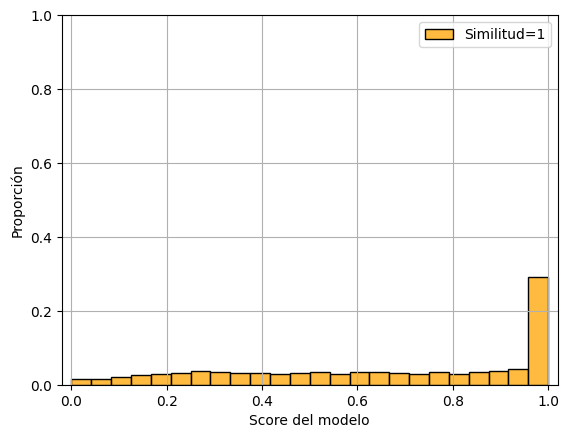

In [226]:
plt.figure()
sns.histplot(test[test.similar==0].pred, bins=np.linspace(0,1, 25), color='darkblue', stat='proportion', label='Similitud=0')
plt.ylabel('Proporción')
plt.xlabel('Score del modelo')
plt.grid()
plt.ylim(0.0,1.0)
plt.xlim(-0.02, 1.02)
plt.legend()



#plt.hist(test[test.similar==0].pred, bins=25)
plt.figure()
plt.grid()
sns.histplot(test[test.similar==1].pred, bins=np.linspace(0,1, 25), color='orange', stat='proportion', label='Similitud=1')
plt.ylabel('Proporción')
plt.xlabel('Score del modelo')
plt.ylim(0.0,1.0)
plt.xlim(-0.02,1.02)
plt.legend()


In [29]:
def plot_roc_curves(roc_vals):
    fpr, tpr = roc_vals
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

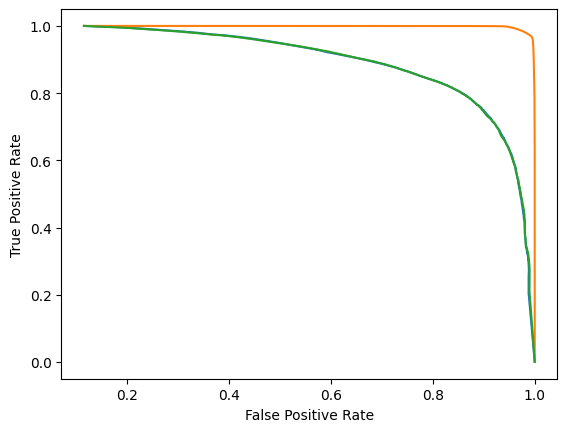

In [32]:
plot_roc_curves(remaining_pr_vals)
plot_roc_curves(train_pr_vals)
plot_roc_curves(test_pr_vals)

Text(0, 0.5, 'True Positive Rate')

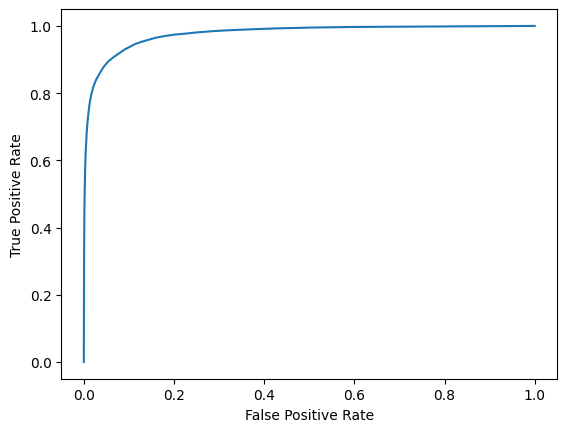

In [42]:
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


0.8999998171442983

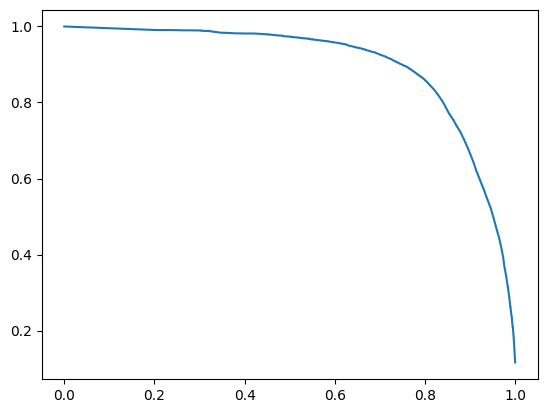

In [45]:
plt.plot(recall, precision)
auc(recall, precision)